In [1]:
import pandas as pd
df_left = pd.read_csv('C:/Users/Minhee KYOUNG/Downloads/ElectionLeftUnique.csv')
df_left.head()

,Unnamed: 0,Comments
0,0,Vice is by far one of the channels with the bi...
1,1,"Dear VICE,\nplease stop with the TikTok effects."
2,2,Editing sucks its downplaying the seriousness ...
3,3,I can’t take her seriously. This report looks ...
4,4,After this vid my brain turned into a desert.


In [20]:
df_left.size

191769

In [2]:
df_right = pd.read_csv('C:/Users/Minhee KYOUNG/Downloads/ElectionRightUnique.csv')
df_right.head()

,Unnamed: 0,Comments
0,0,"Because we don't want you to miss a report, Ch..."
1,1,This was done in blood.. They had so many mont...
2,2,Let the government shut down! We can do better...
3,3,99% of politicians deserve to be wiped from th...
4,4,If they want a fair election then we need an a...


In [21]:
df_right.size

386202

In [3]:
# Lemmatize tokens

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

def lemma(tokens):
    
    def get_wordnet_pos(treebank_tag):

           if treebank_tag.startswith('J'):
               return wordnet.ADJ
           elif treebank_tag.startswith('V'):
               return wordnet.VERB
           elif treebank_tag.startswith('N'):
               return wordnet.NOUN
           elif treebank_tag.startswith('R'):
               return wordnet.ADV
           else:
               return None


    lemmatizer = WordNetLemmatizer()
    tagged_tokens = nltk.pos_tag(tokens)
    lemma_list = list()

    for word, tag in tagged_tokens:
        wtag = get_wordnet_pos(tag)
        if wtag is None:  # not supply tag in case of None
            lem = lemmatizer.lemmatize(word) 
        else:
            lem = lemmatizer.lemmatize(word, pos=wtag)
        lemma_list.append(lem)
        
    return(lemma_list)


# Lowering the characters and Remove special words (e.g. @#$%&), stopwords and short length words
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
import re

def txt_clean(text):
    tokens = word_tokenize(text)
    tokens=lemma(tokens)
    all_stopwords_gensim = STOPWORDS.union(set(['m','s','u' 't', 'd', 'gon', 'na', 've','nt','re']))
    tokens = [word for word in tokens if not word in all_stopwords_gensim]

    result =[]
    for t in tokens:
            pattern='[^\w\s]'
            t = re.sub(pattern=pattern, repl='', string=t)
            shortword = re.compile(r'\W*\b\w{1,2}\b')
            t = shortword.sub('', t)
            if t == '':
                pass
            else:
                result.append(t)
    return result



df_right['Comments'] = df_right['Comments'].str.lower()
df_right['Cleaned'] = df_right['Comments'].apply(lambda x: txt_clean(x))


df_left['Comments'] = df_left['Comments'].str.lower()
df_left['Cleaned'] = df_left['Comments'].apply(lambda x: txt_clean(x))

df_right.head()

,Unnamed: 0,Comments,Cleaned
0,0,"because we don't want you to miss a report, ch...","[want, miss, report, check, brand, new, websit..."
1,1,this was done in blood.. they had so many mont...,"[blood, month, proper, thanks, pelosi, string,..."
2,2,let the government shut down! we can do better...,"[let, government, shut, good]"
3,3,99% of politicians deserve to be wiped from th...,"[politician, deserve, wipe, face, earth]"
4,4,if they want a fair election then we need an a...,"[want, fair, election, need, audit, board]"


# Topic modeling by Latent Dirichlet Allocation (LDA)
[reference] https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess

In [5]:
# find the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Trump-side

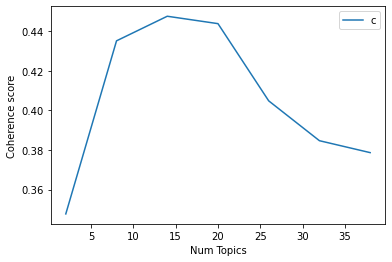

In [6]:
#optimal number of topics
id2word = corpora.Dictionary(df_right['Cleaned'])
texts = df_right['Cleaned']
corpus = [id2word.doc2bow(text) for text in texts]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
NUM_TOPICS = 14 # can change the number of topics according to graph
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=id2word, passes=15)
topics = ldamodel.print_topics(num_words=5) # can change the number of weighted words
for topic in topics:
    print(topic)

(0, '0.071*"people" + 0.055*"american" + 0.055*"money" + 0.053*"country" + 0.038*"need" + 0.032*"want" + 0.029*"time" + 0.020*"new" + 0.018*"politician" + 0.017*"year"')
(1, '0.040*"people" + 0.027*"come" + 0.023*"know" + 0.018*"life" + 0.017*"house" + 0.017*"pelosi" + 0.016*"job" + 0.016*"thing" + 0.014*"white" + 0.014*"nancy"')
(2, '0.076*"graham" + 0.072*"news" + 0.052*"fox" + 0.047*"juan" + 0.043*"real" + 0.030*"medium" + 0.026*"turn" + 0.022*"buy" + 0.020*"crap" + 0.020*"feel"')
(3, '0.067*"pakistan" + 0.059*"love" + 0.035*"million" + 0.032*"tax" + 0.031*"pay" + 0.027*"anthem" + 0.026*"trust" + 0.025*"national" + 0.025*"hope" + 0.025*"rino"')
(4, '0.052*"care" + 0.049*"stop" + 0.033*"work" + 0.026*"people" + 0.025*"problem" + 0.024*"day" + 0.022*"think" + 0.019*"dont" + 0.017*"listen" + 0.015*"virus"')
(5, '0.159*"like" + 0.063*"look" + 0.044*"big" + 0.026*"lie" + 0.024*"tell" + 0.022*"swamp" + 0.019*"ask" + 0.019*"sound" + 0.019*"kid" + 0.015*"people"')
(6, '0.217*"trump" + 0.136

In [22]:
topics = ldamodel.print_topics(num_words=5) # can change the number of weighted words
for topic in topics:
    print(topic)

(0, '0.071*"people" + 0.055*"american" + 0.055*"money" + 0.053*"country" + 0.038*"need"')
(1, '0.040*"people" + 0.027*"come" + 0.023*"know" + 0.018*"life" + 0.017*"house"')
(2, '0.076*"graham" + 0.072*"news" + 0.052*"fox" + 0.047*"juan" + 0.043*"real"')
(3, '0.067*"pakistan" + 0.059*"love" + 0.035*"million" + 0.032*"tax" + 0.031*"pay"')
(4, '0.052*"care" + 0.049*"stop" + 0.033*"work" + 0.026*"people" + 0.025*"problem"')
(5, '0.159*"like" + 0.063*"look" + 0.044*"big" + 0.026*"lie" + 0.024*"tell"')
(6, '0.217*"trump" + 0.136*"president" + 0.056*"win" + 0.038*"biden" + 0.021*"2020"')
(7, '0.063*"woman" + 0.048*"man" + 0.046*"guy" + 0.038*"talk" + 0.028*"obama"')
(8, '0.097*"vote" + 0.059*"democrat" + 0.045*"party" + 0.024*"people" + 0.024*"right"')
(9, '0.055*"watch" + 0.045*"black" + 0.035*"use" + 0.035*"blm" + 0.034*"matter"')
(10, '0.078*"romney" + 0.049*"election" + 0.046*"mitt" + 0.044*"republican" + 0.036*"fraud"')
(11, '0.076*"state" + 0.041*"bad" + 0.038*"business" + 0.033*"open" 

In [18]:
#!pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
pyLDAvis.display(vis)

# Biden-side

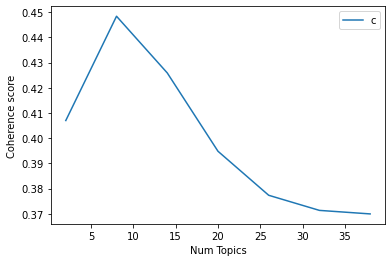

In [10]:
id2word2 = corpora.Dictionary(df_left['Cleaned'])
texts2 = df_left['Cleaned']
corpus2 = [id2word2.doc2bow(text) for text in texts2]

model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word2, corpus=corpus2, texts=texts2, start=2, limit=40, step=6)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [13]:
NUM_TOPICS = 8 # can change adequate the number of topics
ldamodel2 = gensim.models.ldamodel.LdaModel(corpus2, num_topics = NUM_TOPICS, id2word=id2word2, passes=15)
topics2 = ldamodel2.print_topics(num_words=10) # can change the number of weighted words
for topic in topics2:
    print(topic)

(0, '0.042*"vice" + 0.033*"news" + 0.026*"medium" + 0.019*"2020" + 0.015*"fake" + 0.014*"bbc" + 0.010*"report" + 0.010*"video" + 0.009*"tax" + 0.008*"bias"')
(1, '0.018*"law" + 0.018*"protest" + 0.016*"space" + 0.014*"vaccine" + 0.012*"government" + 0.010*"right" + 0.010*"want" + 0.009*"govt" + 0.007*"private" + 0.007*"ask"')
(2, '0.020*"indian" + 0.012*"coffee" + 0.011*"god" + 0.009*"life" + 0.009*"woman" + 0.009*"people" + 0.008*"love" + 0.007*"come" + 0.007*"native" + 0.006*"fight"')
(3, '0.026*"people" + 0.026*"farmer" + 0.015*"country" + 0.015*"world" + 0.015*"good" + 0.014*"india" + 0.011*"like" + 0.009*"need" + 0.009*"year" + 0.008*"work"')
(4, '0.042*"war" + 0.034*"like" + 0.026*"modi" + 0.018*"start" + 0.014*"civil" + 0.013*"sound" + 0.013*"joke" + 0.011*"boy" + 0.011*"care" + 0.010*"proud"')
(5, '0.136*"trump" + 0.088*"biden" + 0.063*"win" + 0.042*"president" + 0.027*"joe" + 0.021*"america" + 0.017*"lose" + 0.016*"election" + 0.013*"american" + 0.012*"nuclear"')
(6, '0.028*"l

# Biden-side

In [16]:
#!pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(ldamodel2, corpus2, id2word2)
pyLDAvis.display(vis2)